In [1]:
# https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-2
# https://keras.io/examples/vision/handwriting_recognition
# https://github.com/pbcquoc/crnn
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'CRNNxExtraTokens'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters 

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=6).remove_rare_chars(2)
print(dataset)

Number of images found: 4069
Number of labels found: 4069
Number of unique characters: 2033
Characters present: {'浪': 308, '㐌': 304, '\U000f070b': 236, '朱': 234, '𠊛': 232, '\U000f047c': 215, '尼': 215, '娘': 206, '𢚸': 202, '固': 201, '吏': 201, '𦋦': 191, '拱': 180, '之': 163, '埃': 159, '群': 153, '𠳒': 150, '情': 147, '芇': 147, '買': 147, '別': 134, '欺': 125, '麻': 125, '𠓨': 124, '𠬠': 124, '仙': 120, '𡗶': 116, '爫': 116, '𧗱': 114, '花': 106, '𦖑': 105, '浽': 104, '𠄩': 102, '呐': 102, '命': 102, '渚': 101, '塘': 99, '饒': 98, '𠫾': 97, '些': 97, '渃': 97, '如': 96, '時': 95, '強': 94, '分': 93, '低': 92, '𡢐': 91, '傷': 91, '払': 91, '牢': 88, '𫽄': 85, '仍': 83, '咍': 82, '冲': 81, '昆': 81, '鐄': 81, '於': 80, '身': 79, '庒': 79, '生': 77, '𧡊': 77, '月': 76, '𢬣': 75, '𣈜': 75, '沛': 74, '調': 74, '茹': 74, '﨤': 72, '皮': 72, '油': 71, '\U000f061a': 71, '細': 71, '催': 70, '公': 70, '典': 70, '緣': 69, '畧': 68, '戈': 68, '碎': 67, '排': 67, '爲': 66, '𠁀': 64, '娥': 64, '\U000f02c7': 62, '包': 61, '共': 61, '貝': 59, '𢧚': 58, '㗂': 57, '恩': 57, '賒': 

## Data constants and input pipeline

In [5]:
HEIGHT = 148
WIDTH = 32
PADDING_CHAR = '[PAD]' 

# Add extra tokens to fit the receptive field for better convergence
# Here used the [START] and [END] tokens for example
START_CHAR = '[START]' 
END_CHAR = '[END]'

In [6]:
from loader import DataHandler
data_handler = DataHandler(
    dataset, 
    img_size = (HEIGHT, WIDTH), 
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

In [7]:
MAX_LENGTH = data_handler.max_length
PADDING_TOKEN = data_handler.padding_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 16

## Visualize the data

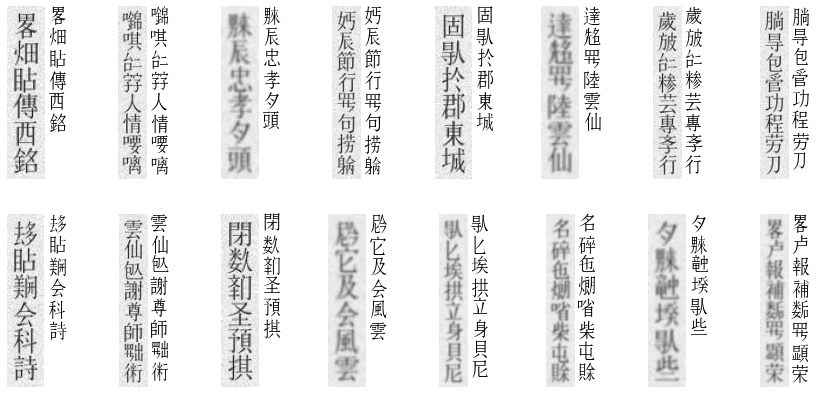

In [8]:
from visualizer import visualize_images_labels
img_paths, labels = dataset.img_paths, dataset.labels 
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

# Define the model

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from cnn import custom_cnn, get_imagenet_model, reshape_for_rnn

In [10]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing the output to the RNN
    x = reshape_for_rnn(x, dim_to_keep=1)

    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.4,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = VOCAB_SIZE + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)
    model = Model(inputs=image_input, outputs=y_pred, name=name)
    return model

In [11]:
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

In [12]:
model = build_crnn(imagenet_model, imagenet_output_layer)
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 image (InputLayer)                          [(None, 148, 32, 1)]                    0              
                                                                                                    
 block1_conv1 (Conv2D)                       (None, 148, 32, 64)                     640            
                                                                                                    
 block1_bn1 (BatchNormalization)             (None, 148, 32, 64)                     256            
                                                                                                    
 block1_activation1 (LeakyReLU)              (None, 148, 32, 64)                     0              
                                                                             

# Training

In [13]:
from tensorflow.keras.optimizers import Adam
from kfold import kfold_decorator
from metrics import MeanEditDistance
from losses import CTCLoss

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from callbacks import EarlyStoppingWithStuck
LEARNING_RATE = 2e-4
EPOCHS = 100

## Callbacks

In [15]:
stuck_str = 'val_loss - loss >= 10 or (epoch > 5 and val_loss > 30)'
early_stopping_callback = EarlyStoppingWithStuck(patience=5, stuck_str=stuck_str)

def scheduler(epoch, lr):
    if epoch < 1 or (epoch % 5) > 0: return lr # Keeps lr for each 5 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [16]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idxs=None, valid_idxs=None):
    train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE)
    valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE)
    
    model.compile(
        optimizer = Adam(learning_rate=LEARNING_RATE), 
        loss = CTCLoss(PADDING_TOKEN), 
        metrics = [MeanEditDistance(PADDING_TOKEN, MAX_LENGTH, use_ctc_decode=True)]
    )
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
            early_stopping_callback,
            reduce_lr_callback, 
#             schedule_lr_callback, 
        ],
        verbose = 1
    ).history
    return valid_tf_dataset, early_stopping_callback.best_epoch, history, model

In [17]:
%%time
valid_datasets, best_epochs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/100
229/229 [==============================] - 17s 44ms/step - loss: 50.3889 - edist: 8.0585 - val_loss: 56.1972 - val_edist: 8.0056 - lr: 2.0000e-04
Epoch 2/100
229/229 [==============================] - 8s 33ms/step - loss: 36.6700 - edist: 5.0505 - val_loss: 29.8953 - val_edist: 5.4723 - lr: 2.0000e-04
Epoch 3/100
229/229 [==============================] - 8s 33ms/step - loss: 20.7895 - edist: 2.4583 - val_loss: 19.2231 - val_edist: 3.5034 - lr: 2.0000e-04
Epoch 4/100
229/229 [==============================] - 8s 34ms/step - loss: 11.8696 - edist: 1.2882 - val_loss: 13.4687 - val_edist: 2.1239 - lr: 2.0000e-04
Epoch 5/100
229/229 [==============================] - 8s 34ms/step - loss: 6.9480 - edist: 0.5677 - val_loss: 9.9429 - val_edist: 1.5270 - lr: 2.0000e-04
Epoch 6/100
229/229 [==============================] - 8s 34ms/step - loss: 4.1170 - edist: 0.1887 - val_loss: 7.7990 - val_edist: 1.0290 - lr: 2.0000e-04
Epoch 7/100
22

229/229 [==============================] - 8s 34ms/step - loss: 0.0148 - edist: 0.0000e+00 - val_loss: 3.0117 - val_edist: 0.5596 - lr: 3.1250e-06
Epoch 47/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0146 - edist: 0.0000e+00 - val_loss: 3.0369 - val_edist: 0.5595 - lr: 3.1250e-06
Epoch 48/100
229/229 [==============================] - ETA: 0s - loss: 0.0146 - edist: 0.0000e+00
Epoch 48: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
229/229 [==============================] - 8s 33ms/step - loss: 0.0146 - edist: 0.0000e+00 - val_loss: 3.0283 - val_edist: 0.5596 - lr: 3.1250e-06
Epoch 49/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0145 - edist: 0.0000e+00 - val_loss: 3.0308 - val_edist: 0.5596 - lr: 1.5625e-06
Epoch 50/100
229/229 [==============================] - ETA: 0s - loss: 0.0144 - edist: 0.0000e+00
Epoch 50: ReduceLROnPlateau reducing learning rate to 1e-06.
229/229 [==============================] - 8s 34ms/

229/229 [==============================] - 8s 35ms/step - loss: 0.0211 - edist: 3.1554e-30 - val_loss: 2.5562 - val_edist: 0.4435 - lr: 1.2500e-05
Epoch 40/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0206 - edist: 3.1554e-30 - val_loss: 2.5931 - val_edist: 0.4449 - lr: 1.2500e-05
Epoch 41/100
229/229 [==============================] - ETA: 0s - loss: 0.0203 - edist: 3.1554e-30
Epoch 41: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 8s 35ms/step - loss: 0.0203 - edist: 3.1554e-30 - val_loss: 2.5868 - val_edist: 0.4840 - lr: 1.2500e-05
Epoch 42/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0203 - edist: 3.1554e-30 - val_loss: 2.5320 - val_edist: 0.4682 - lr: 6.2500e-06
Epoch 43/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0198 - edist: 3.1554e-30 - val_loss: 2.5431 - val_edist: 0.4682 - lr: 6.2500e-06
Epoch 44/100
229/229 [=============================

Epoch 30/100
229/229 [==============================] - ETA: 0s - loss: 0.0405 - edist: 0.0000e+00
Epoch 30: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
229/229 [==============================] - 9s 38ms/step - loss: 0.0405 - edist: 0.0000e+00 - val_loss: 3.6330 - val_edist: 0.7899 - lr: 2.5000e-05
Epoch 31/100
229/229 [==============================] - 9s 38ms/step - loss: 0.0408 - edist: 0.0000e+00 - val_loss: 3.5545 - val_edist: 0.7661 - lr: 1.2500e-05
Epoch 32/100
229/229 [==============================] - 9s 38ms/step - loss: 0.0401 - edist: 7.8886e-31 - val_loss: 3.5571 - val_edist: 0.7841 - lr: 1.2500e-05
Epoch 33/100
229/229 [==============================] - ETA: 0s - loss: 0.0354 - edist: 0.0000e+00
Epoch 33: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 9s 37ms/step - loss: 0.0354 - edist: 0.0000e+00 - val_loss: 3.5692 - val_edist: 0.8037 - lr: 1.2500e-05
Epoch 34/100
229/229 [=============

229/229 [==============================] - 9s 38ms/step - loss: 0.0384 - edist: 1.4552e-11 - val_loss: 2.7346 - val_edist: 0.6605 - lr: 1.0000e-04
Epoch 26/100
229/229 [==============================] - 9s 38ms/step - loss: 0.0356 - edist: 1.4552e-11 - val_loss: 2.7765 - val_edist: 0.7519 - lr: 1.0000e-04
Epoch 27/100
228/229 [============================>.] - ETA: 0s - loss: 0.0329 - edist: 2.9104e-11
Epoch 27: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
229/229 [==============================] - 9s 39ms/step - loss: 0.0329 - edist: 1.4552e-11 - val_loss: 2.7775 - val_edist: 0.7285 - lr: 1.0000e-04
Epoch 28/100
229/229 [==============================] - 9s 40ms/step - loss: 0.0321 - edist: 1.4552e-11 - val_loss: 2.6652 - val_edist: 0.7374 - lr: 5.0000e-05
Epoch 29/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0305 - edist: 1.4552e-11 - val_loss: 2.6867 - val_edist: 0.6571 - lr: 5.0000e-05
Epoch 30/100
229/229 [============================

229/229 [==============================] - 8s 36ms/step - loss: 0.1179 - edist: 0.0000e+00 - val_loss: 3.5412 - val_edist: 0.4928 - lr: 2.0000e-04
Epoch 16/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0955 - edist: 0.0000e+00 - val_loss: 3.4677 - val_edist: 0.4230 - lr: 2.0000e-04
Epoch 17/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0785 - edist: 0.0000e+00 - val_loss: 3.4471 - val_edist: 0.3648 - lr: 2.0000e-04
Epoch 18/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0655 - edist: 0.0000e+00 - val_loss: 3.3685 - val_edist: 0.3359 - lr: 2.0000e-04
Epoch 19/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0557 - edist: 0.0000e+00 - val_loss: 3.3212 - val_edist: 0.3871 - lr: 2.0000e-04
Epoch 20/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0480 - edist: 0.0000e+00 - val_loss: 3.3041 - val_edist: 0.3895 - lr: 2.0000e-04
Epoch 21/100
229/229 [==============================]

229/229 [==============================] - 8s 35ms/step - loss: 0.2710 - edist: 1.4552e-11 - val_loss: 3.3367 - val_edist: 0.5801 - lr: 2.0000e-04
Epoch 13/100
229/229 [==============================] - 8s 35ms/step - loss: 0.2011 - edist: 1.4552e-11 - val_loss: 3.2755 - val_edist: 0.6528 - lr: 2.0000e-04
Epoch 14/100
229/229 [==============================] - 8s 35ms/step - loss: 0.1550 - edist: 1.4552e-11 - val_loss: 3.1764 - val_edist: 0.5525 - lr: 2.0000e-04
Epoch 15/100
229/229 [==============================] - 8s 34ms/step - loss: 0.1234 - edist: 1.4552e-11 - val_loss: 3.0426 - val_edist: 0.6360 - lr: 2.0000e-04
Epoch 16/100
229/229 [==============================] - 8s 34ms/step - loss: 0.1008 - edist: 1.4552e-11 - val_loss: 3.0415 - val_edist: 0.5611 - lr: 2.0000e-04
Epoch 17/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0843 - edist: 1.4552e-11 - val_loss: 2.9588 - val_edist: 0.6200 - lr: 2.0000e-04
Epoch 18/100
229/229 [==============================]

229/229 [==============================] - 13s 39ms/step - loss: 50.8954 - edist: 8.1047 - val_loss: 57.6525 - val_edist: 7.8442 - lr: 2.0000e-04
Epoch 2/100
229/229 [==============================] - 8s 34ms/step - loss: 38.2946 - edist: 5.7117 - val_loss: 33.9169 - val_edist: 6.3843 - lr: 2.0000e-04
Epoch 3/100
229/229 [==============================] - 8s 34ms/step - loss: 21.8482 - edist: 2.7924 - val_loss: 18.7041 - val_edist: 2.8960 - lr: 2.0000e-04
Epoch 4/100
229/229 [==============================] - 8s 34ms/step - loss: 12.3356 - edist: 1.1491 - val_loss: 12.4577 - val_edist: 2.0319 - lr: 2.0000e-04
Epoch 5/100
229/229 [==============================] - 8s 34ms/step - loss: 7.1665 - edist: 0.6247 - val_loss: 8.9606 - val_edist: 1.2988 - lr: 2.0000e-04
Epoch 6/100
229/229 [==============================] - 8s 34ms/step - loss: 4.2314 - edist: 0.2626 - val_loss: 6.7607 - val_edist: 0.9762 - lr: 2.0000e-04
Epoch 7/100
229/229 [==============================] - 8s 34ms/step - los

229/229 [==============================] - ETA: 0s - loss: 0.0307 - edist: 1.4552e-11
Epoch 46: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
229/229 [==============================] - 8s 36ms/step - loss: 0.0307 - edist: 1.4552e-11 - val_loss: 2.5664 - val_edist: 0.5280 - lr: 3.1250e-06
Epoch 47/100
229/229 [==============================] - 8s 36ms/step - loss: 0.0306 - edist: 1.4552e-11 - val_loss: 2.5430 - val_edist: 0.5595 - lr: 1.5625e-06
Epoch 48/100
228/229 [============================>.] - ETA: 0s - loss: 0.0303 - edist: 2.9104e-11
Epoch 48: ReduceLROnPlateau reducing learning rate to 1e-06.
229/229 [==============================] - 9s 39ms/step - loss: 0.0303 - edist: 1.4552e-11 - val_loss: 2.5303 - val_edist: 0.5592 - lr: 1.5625e-06
Epoch 49/100
229/229 [==============================] - 9s 39ms/step - loss: 0.0301 - edist: 1.4552e-11 - val_loss: 2.5494 - val_edist: 0.5631 - lr: 1.0000e-06
Early stopping and restored the model weights from the end of ep

229/229 [==============================] - 9s 38ms/step - loss: 0.0158 - edist: 2.9104e-11 - val_loss: 2.2238 - val_edist: 0.4095 - lr: 1.0000e-04
Epoch 45/100
229/229 [==============================] - 9s 38ms/step - loss: 0.0151 - edist: 2.9104e-11 - val_loss: 2.1440 - val_edist: 0.4087 - lr: 5.0000e-05
Epoch 46/100
229/229 [==============================] - 9s 39ms/step - loss: 0.0147 - edist: 2.9104e-11 - val_loss: 2.1434 - val_edist: 0.4084 - lr: 5.0000e-05
Epoch 47/100
229/229 [==============================] - 9s 39ms/step - loss: 0.0143 - edist: 2.9104e-11 - val_loss: 2.1268 - val_edist: 0.4103 - lr: 5.0000e-05
Epoch 48/100
229/229 [==============================] - 9s 37ms/step - loss: 0.0140 - edist: 2.9104e-11 - val_loss: 2.1891 - val_edist: 0.4022 - lr: 5.0000e-05
Epoch 49/100
229/229 [==============================] - ETA: 0s - loss: 0.0202 - edist: 2.9104e-11
Epoch 49: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
229/229 [============================

229/229 [==============================] - 8s 33ms/step - loss: 0.0389 - edist: 1.4552e-11 - val_loss: 2.2904 - val_edist: 0.2532 - lr: 1.2500e-05
Epoch 30/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0378 - edist: 1.4552e-11 - val_loss: 2.2851 - val_edist: 0.2537 - lr: 1.2500e-05
Epoch 31/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0369 - edist: 1.4552e-11 - val_loss: 2.3135 - val_edist: 0.2513 - lr: 1.2500e-05
Epoch 32/100
229/229 [==============================] - ETA: 0s - loss: 0.0362 - edist: 1.4552e-11
Epoch 32: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
229/229 [==============================] - 8s 33ms/step - loss: 0.0362 - edist: 1.4552e-11 - val_loss: 2.3185 - val_edist: 0.2517 - lr: 1.2500e-05
Epoch 33/100
229/229 [==============================] - 8s 35ms/step - loss: 0.0360 - edist: 1.4552e-11 - val_loss: 2.2547 - val_edist: 0.2459 - lr: 6.2500e-06
Epoch 34/100
229/229 [=============================

Epoch 26/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0298 - edist: 0.0000e+00 - val_loss: 3.2684 - val_edist: 0.6028 - lr: 5.0000e-05
Epoch 27/100
229/229 [==============================] - ETA: 0s - loss: 0.0282 - edist: 0.0000e+00
Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
229/229 [==============================] - 8s 34ms/step - loss: 0.0282 - edist: 0.0000e+00 - val_loss: 3.3029 - val_edist: 0.6087 - lr: 5.0000e-05
Epoch 28/100
229/229 [==============================] - 8s 34ms/step - loss: 0.0278 - edist: 0.0000e+00 - val_loss: 3.2161 - val_edist: 0.6062 - lr: 2.5000e-05
Epoch 29/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0268 - edist: 0.0000e+00 - val_loss: 3.2145 - val_edist: 0.6008 - lr: 2.5000e-05
Epoch 30/100
229/229 [==============================] - 8s 33ms/step - loss: 0.0258 - edist: 0.0000e+00 - val_loss: 3.2313 - val_edist: 0.6011 - lr: 2.5000e-05
Epoch 31/100
229/229 [===============

## Get the best CRNN model and its results

In [18]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_fold_epoch,
    best_history,
    best_model,
    best_fold_idx, 
    best_loss,
) = get_best_fold(valid_datasets, best_epochs, histories, models)

26/26 [==============================] - 1s 18ms/step - loss: 3.1214 - edist: 0.6510


Fold 08 has the best result at epoch 52:
- Loss on validation: 2.105973482131958
- Mean edit distance: 0.34426039457321167


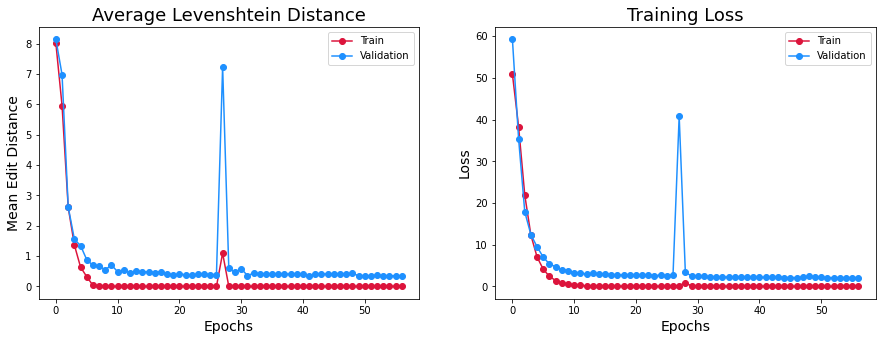

In [19]:
print(f'Fold {best_fold_idx + 1:02d} has the best result at epoch {best_fold_epoch + 1}:')
print(f'- Loss on validation: {best_loss}')
print(f'- Mean edit distance: {best_history["val_edist"][best_fold_epoch]}')
plot_training_results(best_history, f'{APPROACH_NAME}.png')
best_model.save(f'{APPROACH_NAME}.h5')

# Inference

In [20]:
from tensorflow.keras.models import Model, load_model
reloaded_model = load_model(f'{APPROACH_NAME}.h5', custom_objects={
    'CTCLoss': CTCLoss, 
    'MeanEditDistance': MeanEditDistance
})
reloaded_model.summary(line_length=100)

Model: "Model_08"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 image (InputLayer)                          [(None, 148, 32, 1)]                    0              
                                                                                                    
 block1_conv1 (Conv2D)                       (None, 148, 32, 64)                     640            
                                                                                                    
 block1_bn1 (BatchNormalization)             (None, 148, 32, 64)                     256            
                                                                                                    
 block1_activation1 (LeakyReLU)              (None, 148, 32, 64)                     0              
                                                                         

## On test dataset

Batch 01:
- True: {1: '尊師欺意論盘', 2: '丕𡢐𠦳淡登程買安', 3: '柴盘𠬠𭛣科期群賖', 4: '雖浪㵢泣尼匕', 5: '呂\U000f047c柴沛𣴓唎爫之', 6: '計自昔淡細𫢩', 7: '呌蹺𨅸吏𤑟𢈱分戈', 8: '風來庄及阻𢬣', 9: '寬寬𡎢妬渚𦋦', 10: '\U000f0087油𠦳淡塘車拱仃', 11: '別𡆫催固上程爫之', 12: '𧵑錢\U000f0778固泊鐄拱空', 13: '哙戈𠸜户𠬠欺朱詳', 14: '\U000f0778咍君子圭鄕尼芇', 15: '汝勾重\U000f0482輕財', 16: '云仙𥄭吏𢚸唹'}
- Pred: {1: '尊師欺意論盘', 2: '丕𡢐𠦳淡登程買安', 3: '柴盘𠬠𭛣科期群賖', 4: '雖浪㵢泣尼匕', 5: '呂\U000f047c柴沛𣴓呐爫之', 6: '計自昔淡細𫢩', 7: '呌蹺𨅸吏𤑟𢈱分戈', 8: '風來庄及阻𢬣', 9: '責寬𡎢妬渚𦋦', 10: '\U000f0087油𠦳淡塘車拱仃', 11: '別圍催固王程爫之', 12: '𧵑錢\U000f0778固泊鐄拱空', 13: '哙戈𠸜户𠬠欺朱詳', 14: '\U000f0778咍君子圭鄕尼芇', 15: '汝勾重\U000f0482輕𨱽', 16: '云仙𥄭吏𢚸唹'}

Batch 02:
- True: {1: '詩耒尼妾吀𤼸', 2: '㐌毛麻吏添咍', 3: '月娥嘆哭情喂\U000f047c情', 4: '矯公䀡𧡊𢚸強生𪟽', 5: '月娥胣唉嵬匕', 6: '芇埃女底朱埃𠹾煩', 7: '𮎦䧺吏﨤𮎦雄𠬠欺', 8: '答浪些拱𠖈詩', 9: '云仙群唉囬鄕咏茄', 10: '𢜠浪𫢩𧡊昆些', 11: '仍𠲖几晋𠊛秦', 12: '公浪昆篤𠖈詩', 13: '双離堆妸交掑', 14: '直浪仙本高才', 15: '直浪嗔讓仙\U000f0268爫英', 16: '移蹎𣃣課平明'}
- Pred: {1: '詩耒尼妾吀摸', 2: '㐌毛麻吏添咍', 3: '月娥嘆哭情喂\U000f047c情', 4: '矯公䀡𧡊𢚸強生𪟽', 5: '月娥胣唉嵬匕', 6: '芇埃女底朱埃𠹾煩', 7: '𮎦䧺吏﨤𮎦雄𠬠欺', 8: '答浪些拱𠖈詩', 9: '云仙群唉囬鄕咏茄', 10: '𢜠

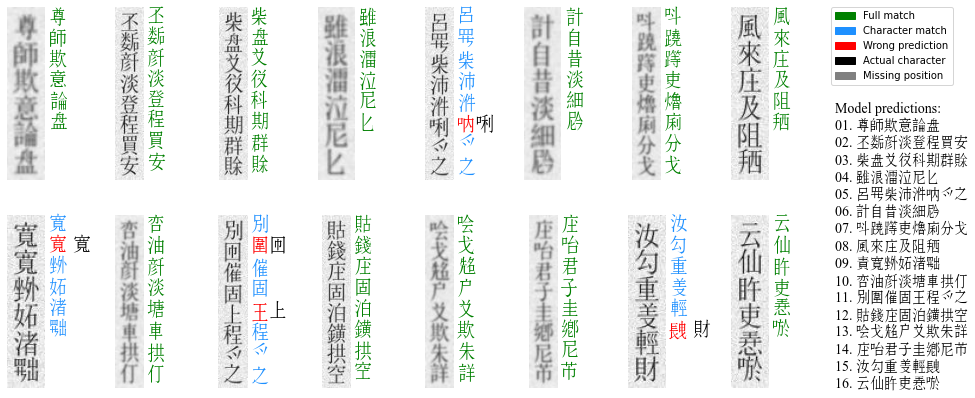

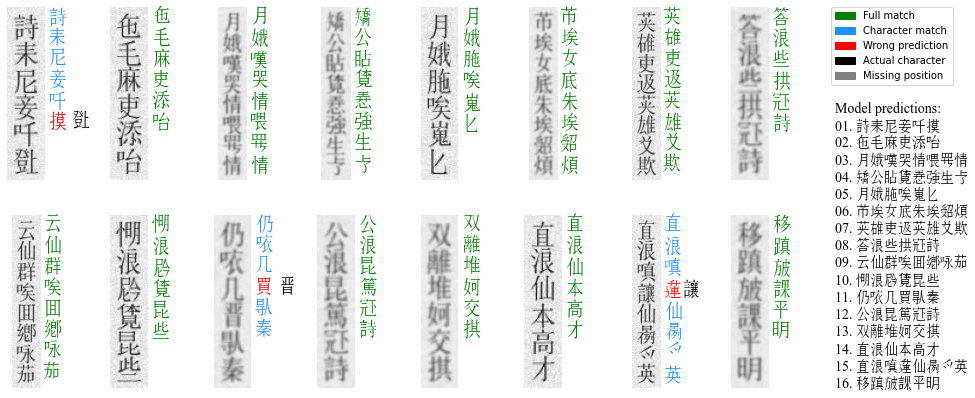

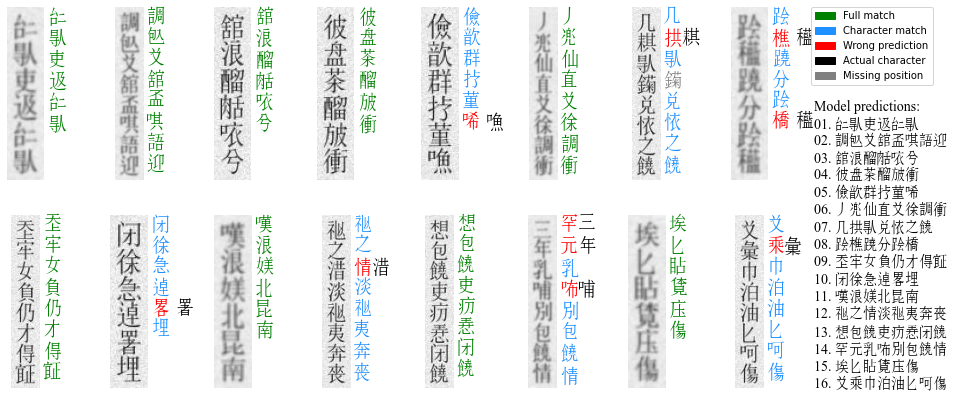

In [21]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, (batch_images, batch_tokens) in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    pred_tokens = reloaded_model.predict(batch_images)
    
    labels = data_handler.tokens2texts(batch_tokens)
    pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)
    
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [22]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = data_handler.process_image(random_path)
pred_tokens = reloaded_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)

Predicted text: 大越史記全書


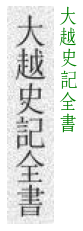

In [23]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))